In [1]:
import importlib
import src.utils.config_loader
importlib.reload(src.utils.config_loader)

from src.utils.config_loader import ConfigLoader

config_loader = ConfigLoader()
all_configs = config_loader.load_configs()
base_configs = config_loader.get_section(all_configs, "base")
graph_configs = config_loader.get_section(all_configs, "graph")
community_cfg = config_loader.get_section(all_configs, "community")

In [2]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}") # type: ignore

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

PyTorch version: 2.5.1
CUDA available: True
CUDA version: 12.4


device(type='cuda')

In [3]:
# Preprocess data
import importlib
import src.modules.data_processor
importlib.reload(src.modules.data_processor)

from src.modules.data_processor import DataProcessor

print(base_configs)
data_processor = DataProcessor(base_configs=base_configs)
processed_data = data_processor.run(device=device, summarize=False)

{'paths': {'raw': 'data/raw/deb_label.csv', 'processed': 'data/processed'}, 'labels': {0: 'disagree', 1: 'neutral', 2: 'agree'}, 'subreddits': {'brexit': 0, 'blacklivesmatter': 1, 'climate': 2, 'democrats': 3, 'republican': 4}, 'required_columns': ['label', 'msg_id_parent', 'msg_id_child', 'submission_id', 'body_parent', 'body_child', 'submission_text', 'subreddit', 'author_parent', 'author_child', 'datetime', 'agreement_fraction', 'individual_kappa'], 'cleaning': {'normalize_subreddits': True, 'rename_columns': {'author_child': 'src_author', 'author_parent': 'dst_author', 'msg_id_child': 'src_comment_id', 'msg_id_parent': 'dst_comment_id', 'body_child': 'src_comment_text', 'body_parent': 'dst_comment_text', 'datetime': 'timestamp'}, 'timestamp_parsing': {'primary_format': '%d/%m/%Y %H:%M', 'dayfirst': True, 'error_handling': 'coerce', 'fallback_formats': ['%Y-%m-%d %H:%M:%S', '%m/%d/%Y %H:%M', '%Y-%m-%d']}, 'remove_self_replies': True}, 'temporal': {'infer_parent_comment_time': {'enab

In [4]:
# Build graphs
import importlib
import src.modules.graph_processor
importlib.reload(src.modules.graph_processor)

from src.modules.graph_processor import GraphProcessor

processed_path = base_configs.get('processed_path', 'data/processed')
pairs = processed_data.user_pairs
comments = processed_data.comments

graph_processor = GraphProcessor(graph_configs=graph_configs, processed_path=processed_path)
graph_data = graph_processor.run(pairs=pairs, embeddings_source=comments)

Building node features with pooling: mean
    + Total unique authors in pairs: 35257
    + Total pooled vectors: 35212
    + Pooled vector dimension: 384
Building graph snapshots: directed=True, wcc_mode=min_edges, edge_attrs=['mean_confidence', 'net_vector']
[Subreddit 0, T0] [WCC:min_edges] Nodes 32->29, Edges 86->84 (2.3% edges removed)
[Subreddit 0, T1] [WCC:min_edges] Nodes 30->30, Edges 79->79 (0.0% edges removed)
[Subreddit 0, T2] [WCC:min_edges] Nodes 31->31, Edges 59->59 (0.0% edges removed)
[Subreddit 0, T3] [WCC:min_edges] Nodes 43->43, Edges 107->107 (0.0% edges removed)
[Subreddit 0, T4] [WCC:min_edges] Nodes 53->53, Edges 134->134 (0.0% edges removed)
[Subreddit 0, T5] [WCC:min_edges] Nodes 71->71, Edges 266->266 (0.0% edges removed)
[Subreddit 0, T6] [WCC:min_edges] Nodes 79->79, Edges 187->187 (0.0% edges removed)
[Subreddit 0, T7] [WCC:min_edges] Nodes 96->94, Edges 177->176 (0.6% edges removed)
[Subreddit 0, T8] [WCC:min_edges] Nodes 187->187, Edges 611->611 (0.0% edg

[Subreddit 0, T11] [WCC:min_edges] Nodes 263->261, Edges 944->943 (0.1% edges removed)
[Subreddit 0, T12] [WCC:min_edges] Nodes 330->330, Edges 1414->1414 (0.0% edges removed)
[Subreddit 0, T13] [WCC:min_edges] Nodes 272->265, Edges 701->697 (0.6% edges removed)
[Subreddit 0, T14] [WCC:min_edges] Nodes 307->307, Edges 1196->1196 (0.0% edges removed)
[Subreddit 0, T15] [WCC:min_edges] Nodes 293->291, Edges 1195->1194 (0.1% edges removed)
[Subreddit 0, T16] [WCC:min_edges] Nodes 210->206, Edges 608->606 (0.3% edges removed)
[Subreddit 0, T17] [WCC:min_edges] Nodes 257->257, Edges 1007->1007 (0.0% edges removed)
[Subreddit 0, T18] [WCC:min_edges] Nodes 266->264, Edges 948->947 (0.1% edges removed)
[Subreddit 0, T19] [WCC:min_edges] Nodes 267->265, Edges 893->892 (0.1% edges removed)
[Subreddit 0, T20] [WCC:min_edges] Nodes 331->331, Edges 1377->1377 (0.0% edges removed)
[Subreddit 0, T21] [WCC:min_edges] Nodes 225->221, Edges 544->542 (0.4% edges removed)
[Subreddit 0, T22] [WCC:min_edges

/home/jovyan/github/ecs_msc_project/src/modules/graph_processor.py:177: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647378361/work/torch/csrc/utils/tensor_new.cpp:278.)
  x = torch.tensor(node_features, dtype=torch.float)


    + Created 77 PyG graphs
Saved PyG graphs to data/processed/pyg_graphs_384D.pt


In [11]:
# Import the ECS processor
from src.modules.ecs_processor import ECSProcessor, create_ecs_processor

ckpt_path = "checkpoints/best_model_2509011326.pth"
model_class_path = "src.models.multitask_debate_gnn.MultitaskDebateGNN"

ecs_processor = create_ecs_processor(
    base_configs=base_configs,
    community_configs=community_cfg,
    gnn_model_path=ckpt_path,
    gnn_model_class_path=model_class_path,
    device=device   # type: ignore
)

# Process all graphs
pyg_graphs, graph_dict = graph_data.pyg_graphs, graph_data.graph_dict
processed_dict = ecs_processor.process_graphs(pyg_graphs, graph_dict)

# Get results DataFrame
ecs_df = ecs_processor.get_results_dataframe()
print(f"Processed {len(processed_dict)} subreddits")

Loading model checkpoint from checkpoints/best_model_2509011326.pth
Loaded GNN model: MultitaskDebateGNN
Starting ECS processing for 77 graphs
Processing graph for subreddit: 0, timestep: 0
  Extracted node mapping: 29 nodes
  Graph stats: 29 nodes, 84 edges
Using device: cuda


  Communities found: 3
  Community sizes (min=6): [np.int64(13), np.int64(10), np.int64(6)]
  Modularity: 0.238
  EchoGAE ECI: 0.4899 | Community ECIs: ['0.4152', '0.5592', '0.5362']
  DebateGNN ECI: 0.5260 | Community ECIs: ['0.5841', '0.4688', '0.4954']
  **Embedding-Community Alignment Analysis**
    EchoGAE Embedding-Community Alignment:
    Silhouette Score: -0.1163 (higher = better separation)
    + Avg Intra-Community Distance: 0.9887
    + Avg Inter-Community Distance: 0.9064
    + Distance Ratio (Inter/Intra): 0.9167
    DebateGNN Embedding-Community Alignment:
    Silhouette Score: -0.0412 (higher = better separation)
    + Avg Intra-Community Distance: 0.4792
    + Avg Inter-Community Distance: 0.5173
    + Distance Ratio (Inter/Intra): 1.0797
  **End Alignment Analysis**

Processing graph for subreddit: 0, timestep: 1
  Extracted node mapping: 30 nodes
  Graph stats: 30 nodes, 79 edges
Using device: cuda
  Communities found: 2
  Community sizes (min=9): [np.int64(21), np.in

Running complete ECS analysis with figure generation...
   + Color mode: lineage
Starting complete ECS analysis with pre-computed results...
Analyzing community evolution...
Computing evolution for brexit across 23 timesteps: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]

--- Timestep 0 -> 1 ---
Communities: 3 -> 2
Total Jaccard (Hungarian): 0.448
User Retention: 72.4%

--- Timestep 1 -> 2 ---
Communities: 2 -> 2
Total Jaccard (Hungarian): 0.400
User Retention: 70.0%

--- Timestep 2 -> 3 ---
Communities: 2 -> 4
Total Jaccard (Hungarian): 0.310
User Retention: 74.2%

--- Timestep 3 -> 4 ---
Communities: 4 -> 4
Total Jaccard (Hungarian): 0.669
User Retention: 79.1%

--- Timestep 4 -> 5 ---
Communities: 4 -> 3
Total Jaccard (Hungarian): 0.596
User Retention: 86.8%

--- Timestep 5 -> 6 ---
Communities: 3 -> 2
Total Jaccard (Hungarian): 0.462
User Retention: 78.9%

--- Timestep 6 -> 7 ---
Communities: 2 -> 2
Total Jaccard (Hungarian): 0.344
User Retentio

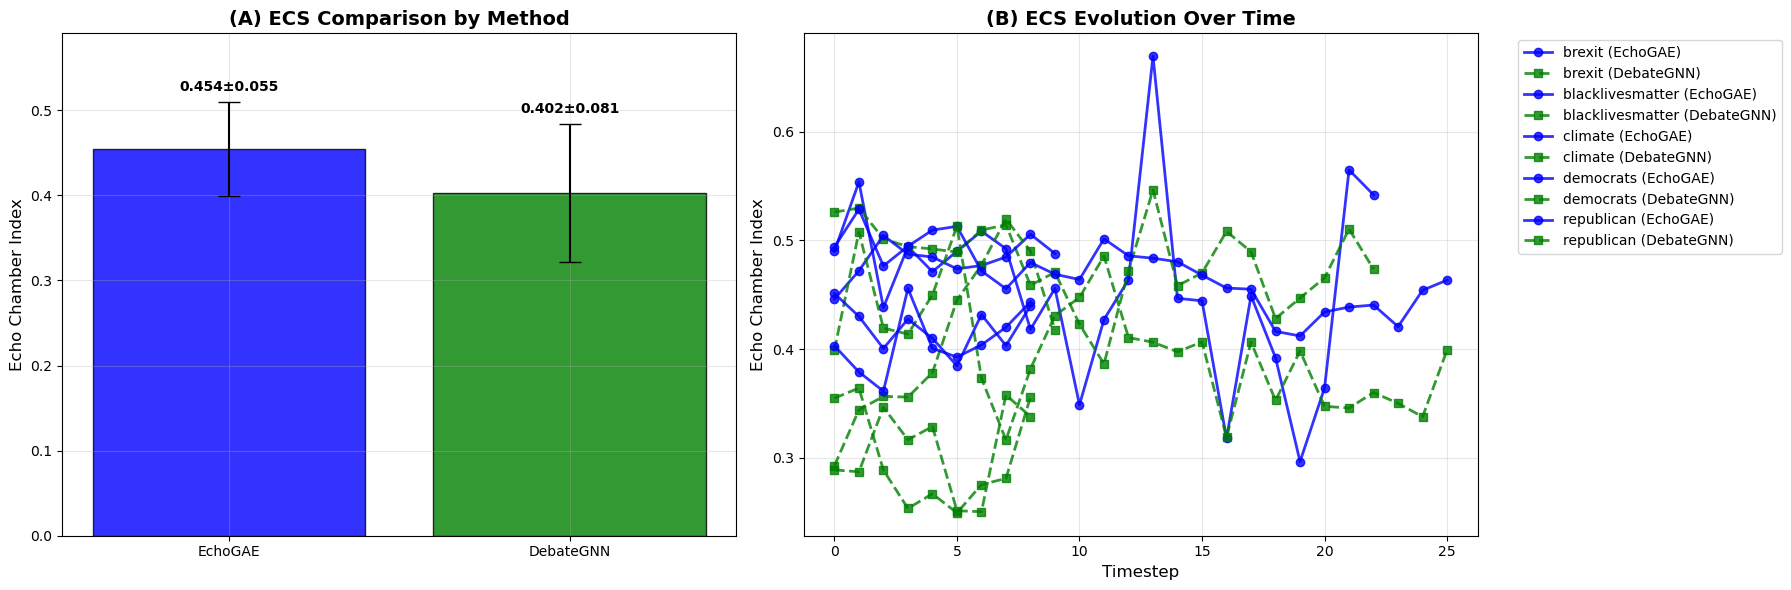

Generating Figure 2: Community Evolution Analysis...


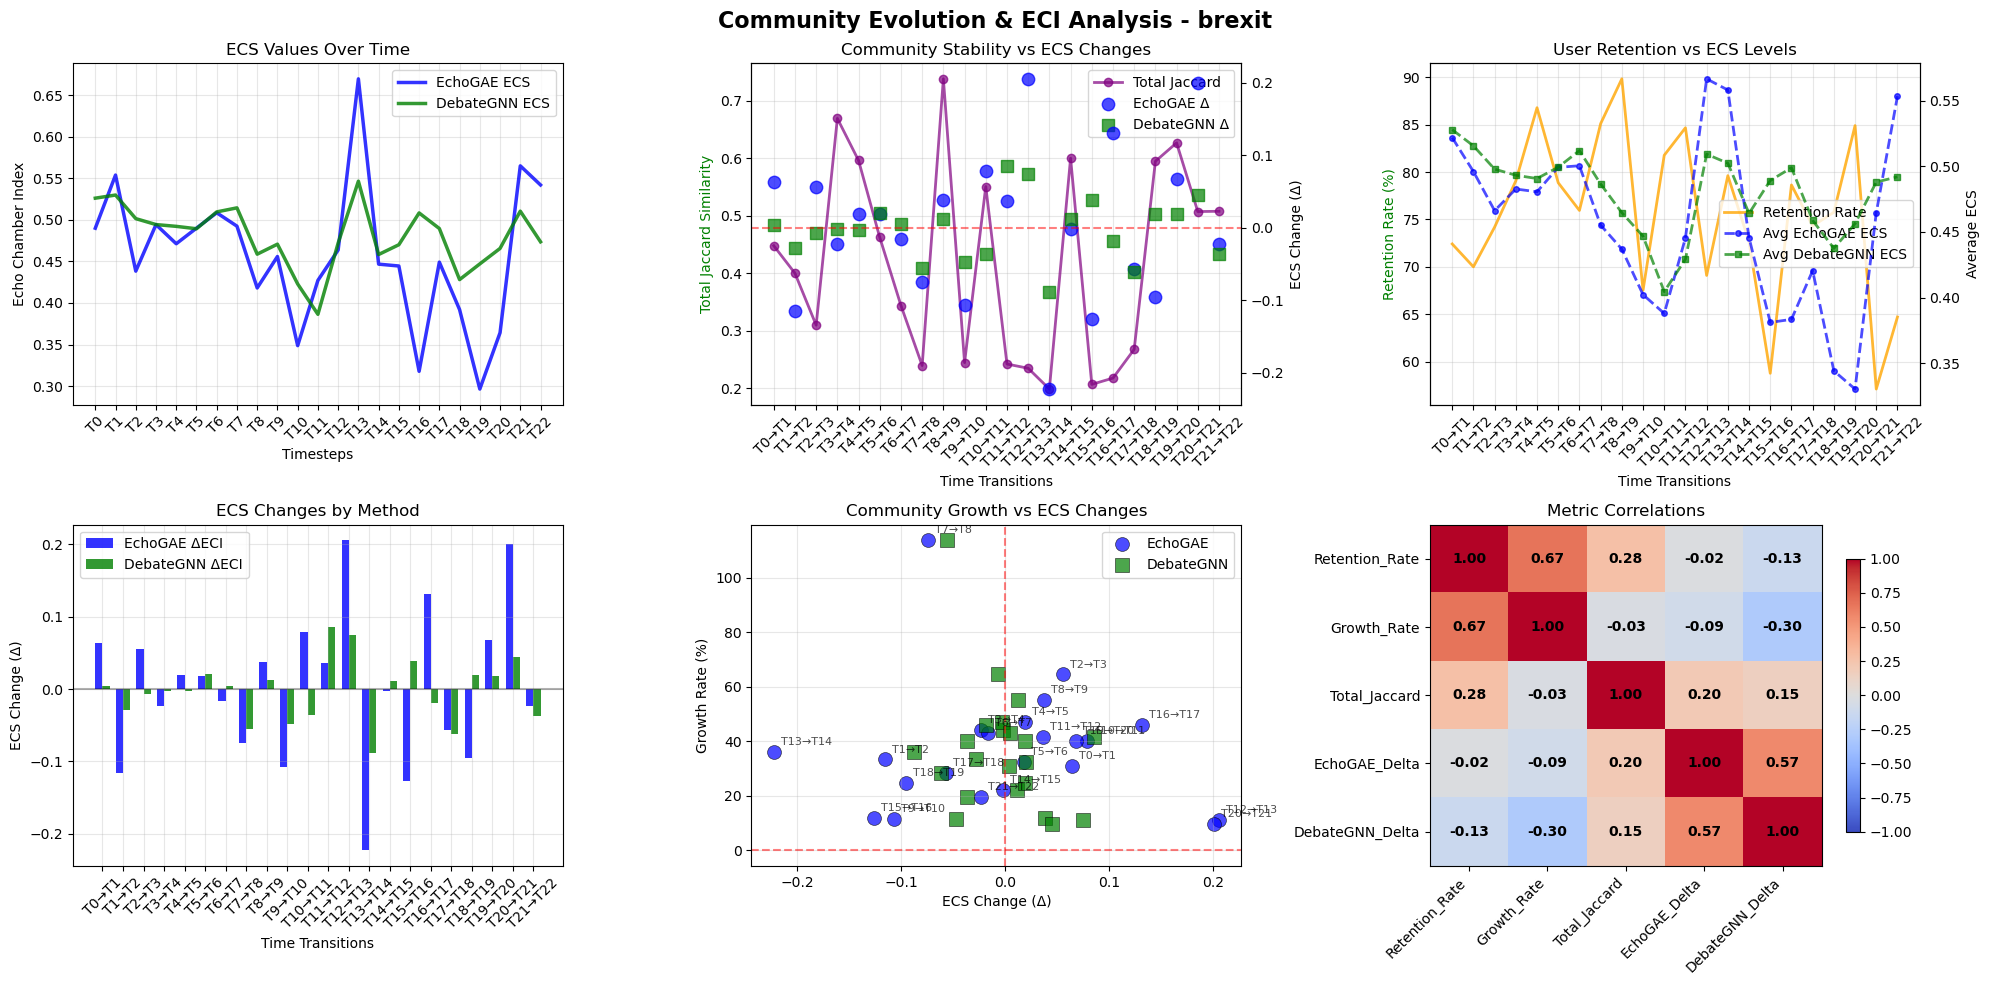


COMPREHENSIVE ANALYSIS SUMMARY - brexit

ECS EVOLUTION:
  + T0: EchoGAE=0.4899, DebateGNN=0.5260
  + T1: EchoGAE=0.5538, DebateGNN=0.5298
  + T2: EchoGAE=0.4383, DebateGNN=0.5014
  + T3: EchoGAE=0.4942, DebateGNN=0.4943
  + T4: EchoGAE=0.4712, DebateGNN=0.4921
  + T5: EchoGAE=0.4900, DebateGNN=0.4892
  + T6: EchoGAE=0.5085, DebateGNN=0.5095
  + T7: EchoGAE=0.4923, DebateGNN=0.5143
  + T8: EchoGAE=0.4181, DebateGNN=0.4587
  + T9: EchoGAE=0.4558, DebateGNN=0.4707
  + T10: EchoGAE=0.3487, DebateGNN=0.4229
  + T11: EchoGAE=0.4272, DebateGNN=0.3864
  + T12: EchoGAE=0.4637, DebateGNN=0.4720
  + T13: EchoGAE=0.6694, DebateGNN=0.5464
  + T14: EchoGAE=0.4467, DebateGNN=0.4583
  + T15: EchoGAE=0.4445, DebateGNN=0.4700
  + T16: EchoGAE=0.3178, DebateGNN=0.5082
  + T17: EchoGAE=0.4491, DebateGNN=0.4895
  + T18: EchoGAE=0.3920, DebateGNN=0.4281
  + T19: EchoGAE=0.2965, DebateGNN=0.4470
  + T20: EchoGAE=0.3643, DebateGNN=0.4656
  + T21: EchoGAE=0.5648, DebateGNN=0.5104
  + T22: EchoGAE=0.5419, Deba

/opt/conda/envs/mscenv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



/opt/conda/envs/mscenv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



  NetworkX coloring: 330 nodes with colors, 0 nodes without colors
  Community layout: 6 communities for positioning


<Figure size 640x480 with 0 Axes>

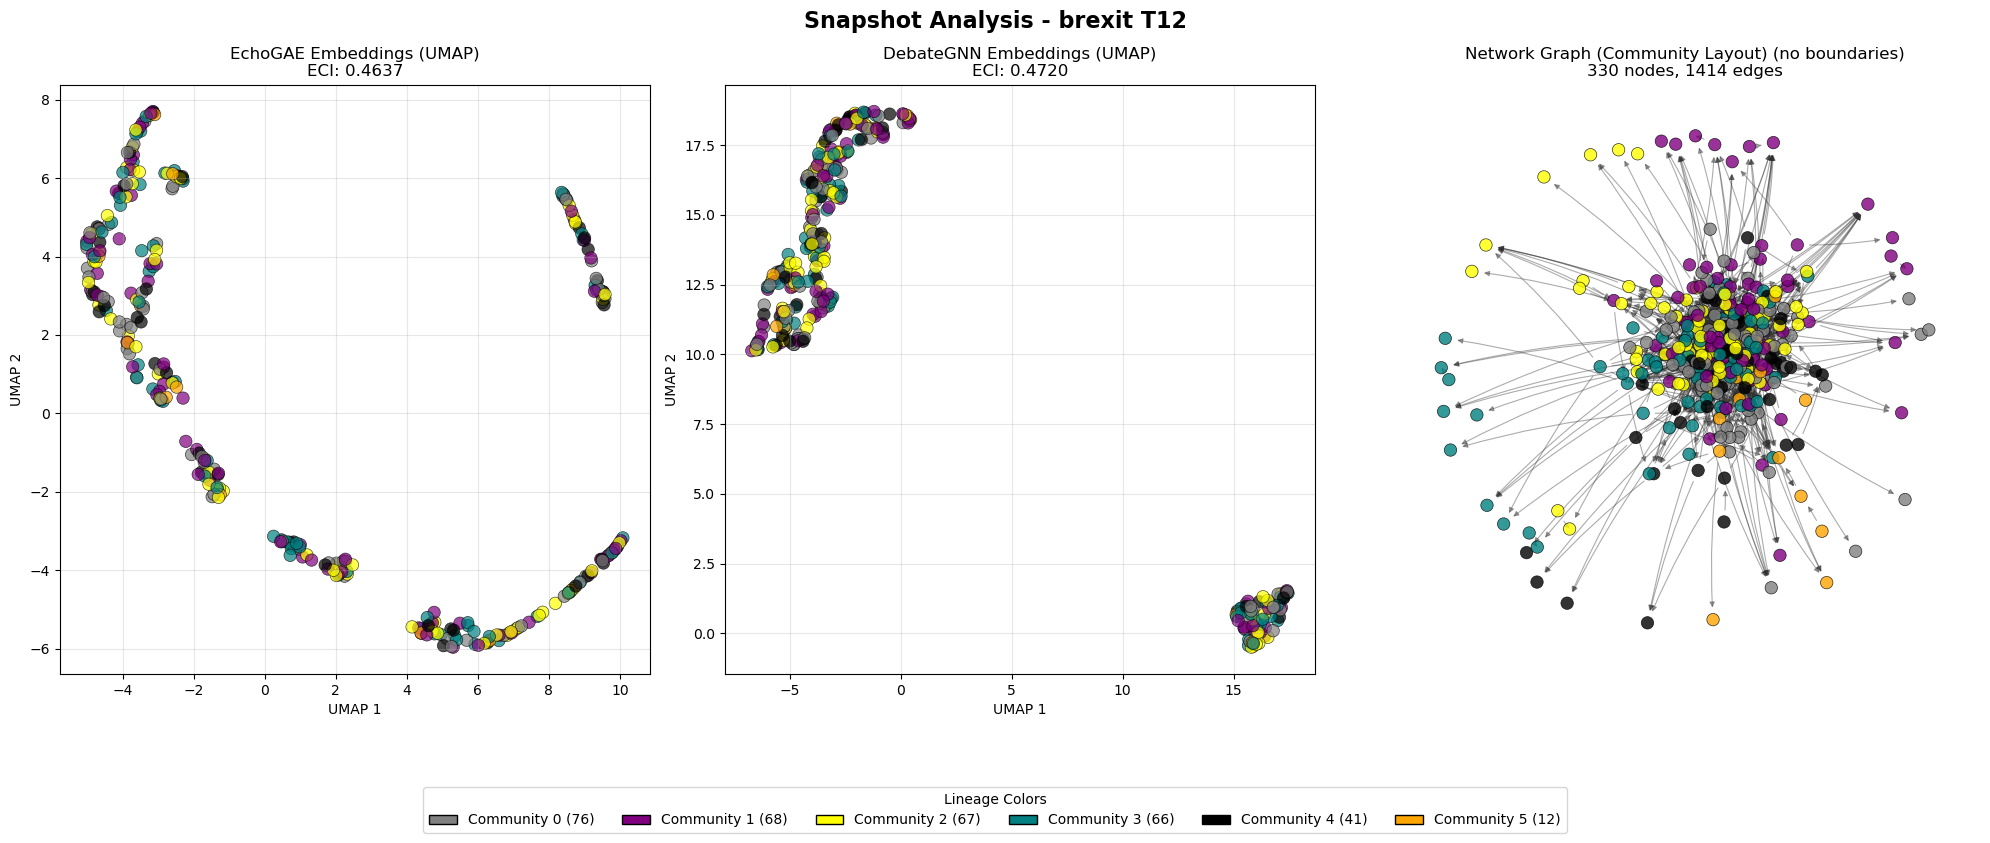


SNAPSHOT SUMMARY - brexit T12
Communities: 6
Nodes: 330
Edges: 1414
Modularity: 0.277
EchoGAE ECI: 0.4637
DebateGNN ECI: 0.4720
Color scheme: Lineage Colors
Boundaries drawn: False
  Community 0: 76 nodes, EchoGAE ECI: 0.4920, DebateGNN ECI: 0.4926
  Community 1: 68 nodes, EchoGAE ECI: 0.5064, DebateGNN ECI: 0.4521
  Community 2: 67 nodes, EchoGAE ECI: 0.4850, DebateGNN ECI: 0.4652
  Community 3: 66 nodes, EchoGAE ECI: 0.4124, DebateGNN ECI: 0.4597
  Community 4: 41 nodes, EchoGAE ECI: 0.4274, DebateGNN ECI: 0.4925
  Community 5: 12 nodes, EchoGAE ECI: 0.3306, DebateGNN ECI: 0.4910
Debug: evolution_data type = <class 'dict'>
Debug: Passing color_mode 'lineage' to Sankey plot
Using 32 colors for lineage mode
Max communities per timestep: 7

=== SANKEY COLOR DEBUG ===
Sample color mappings from Sankey:
  0_0: #0000FF
  0_1: #FF0000
  0_2: #00FF00
  1_0: #000080
  1_1: #FF00FF
  2_0: #008000
  2_1: #800000
  3_0: #00FFFF
  3_1: #808080
  3_2: #800080

Analyzing ALL user flows with thresh


ALL FLOWS SANKEY SUMMARY - r/brexit - Community Flow Analysis
FILTERING RESULTS:
  + Total possible flows: 271
  + Flows after filtering: 119
  + Filtered out: 152 (56.1%)
  + Filter efficiency: 43.9% flows retained

FLOW STATISTICS:
  + Total nodes (communities): 80
  + Total links (significant flows): 119
  + Total users in flows: 2,802
  + Average flow size: 23.5 users
  + Average Jaccard similarity: 0.150

FLOW STRENGTH DISTRIBUTION:
  + Strong: 5 flows (4.2%)
  + Medium: 2 flows (1.7%)
  + Low: 65 flows (54.6%)
  + Very Low: 47 flows (39.5%)
  T0 → T1: 2 flows, 15 total users, avg Jaccard: 0.304
  T1 → T2: 2 flows, 20 total users, avg Jaccard: 0.297
  T2 → T3: 3 flows, 18 total users, avg Jaccard: 0.172
  T3 → T4: 7 flows, 26 total users, avg Jaccard: 0.165
  T4 → T5: 9 flows, 42 total users, avg Jaccard: 0.146
  T5 → T6: 6 flows, 56 total users, avg Jaccard: 0.176
  T6 → T7: 2 flows, 57 total users, avg Jaccard: 0.282
  T7 → T8: 6 flows, 76 total users, avg Jaccard: 0.115
  T8 →

<Figure size 640x480 with 0 Axes>

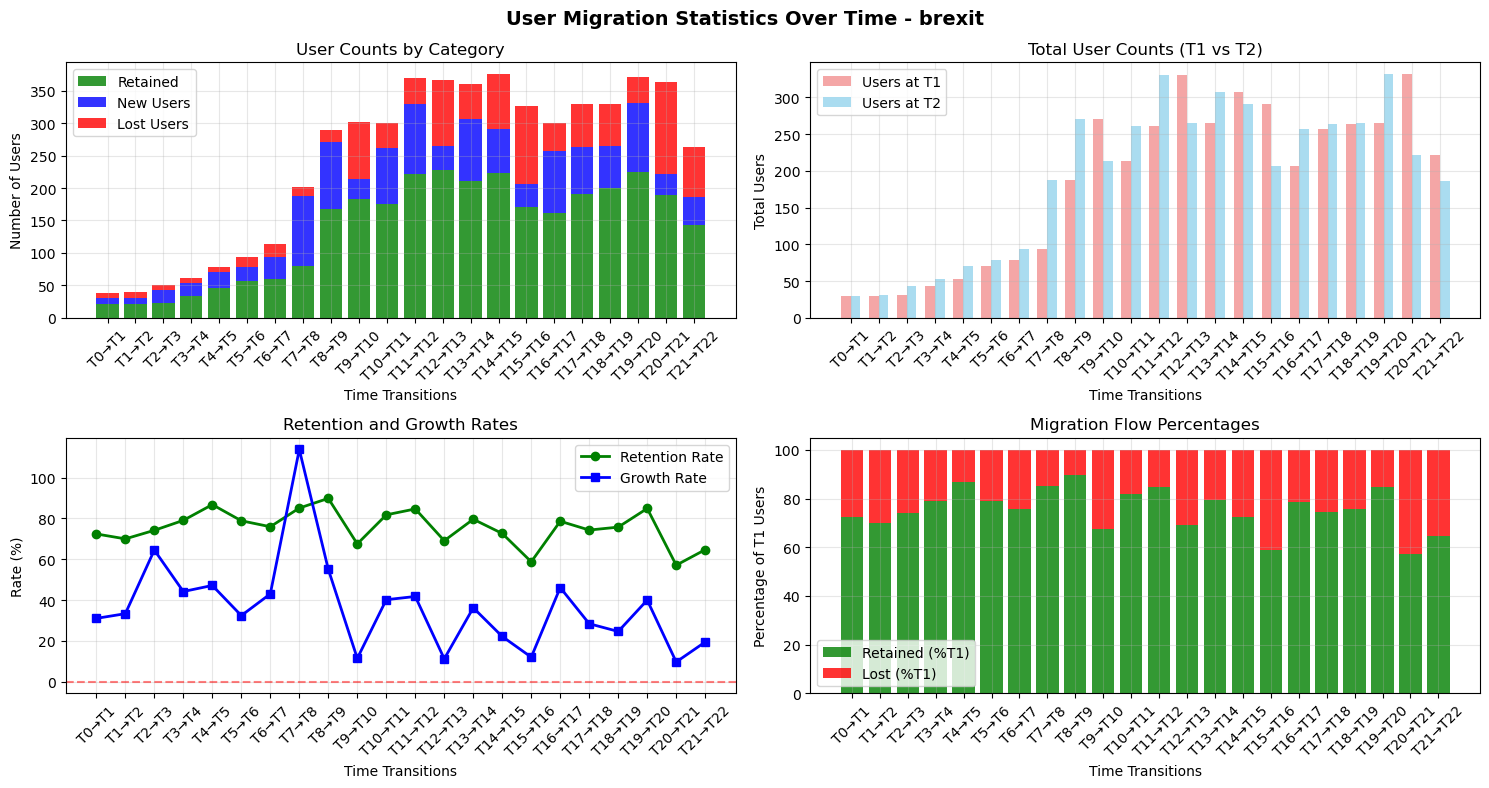

Generating Figure 6: Network Evolution Grid...
  Using lineage colors for network evolution grid
Using 32 colors for lineage mode
Max communities per timestep: 7
Generating network evolution grid with 23 timesteps
Using color mode: lineage
Network evolution grid saved to: results/ecs/figure6_network_evolution_grid.png


<Figure size 640x480 with 0 Axes>

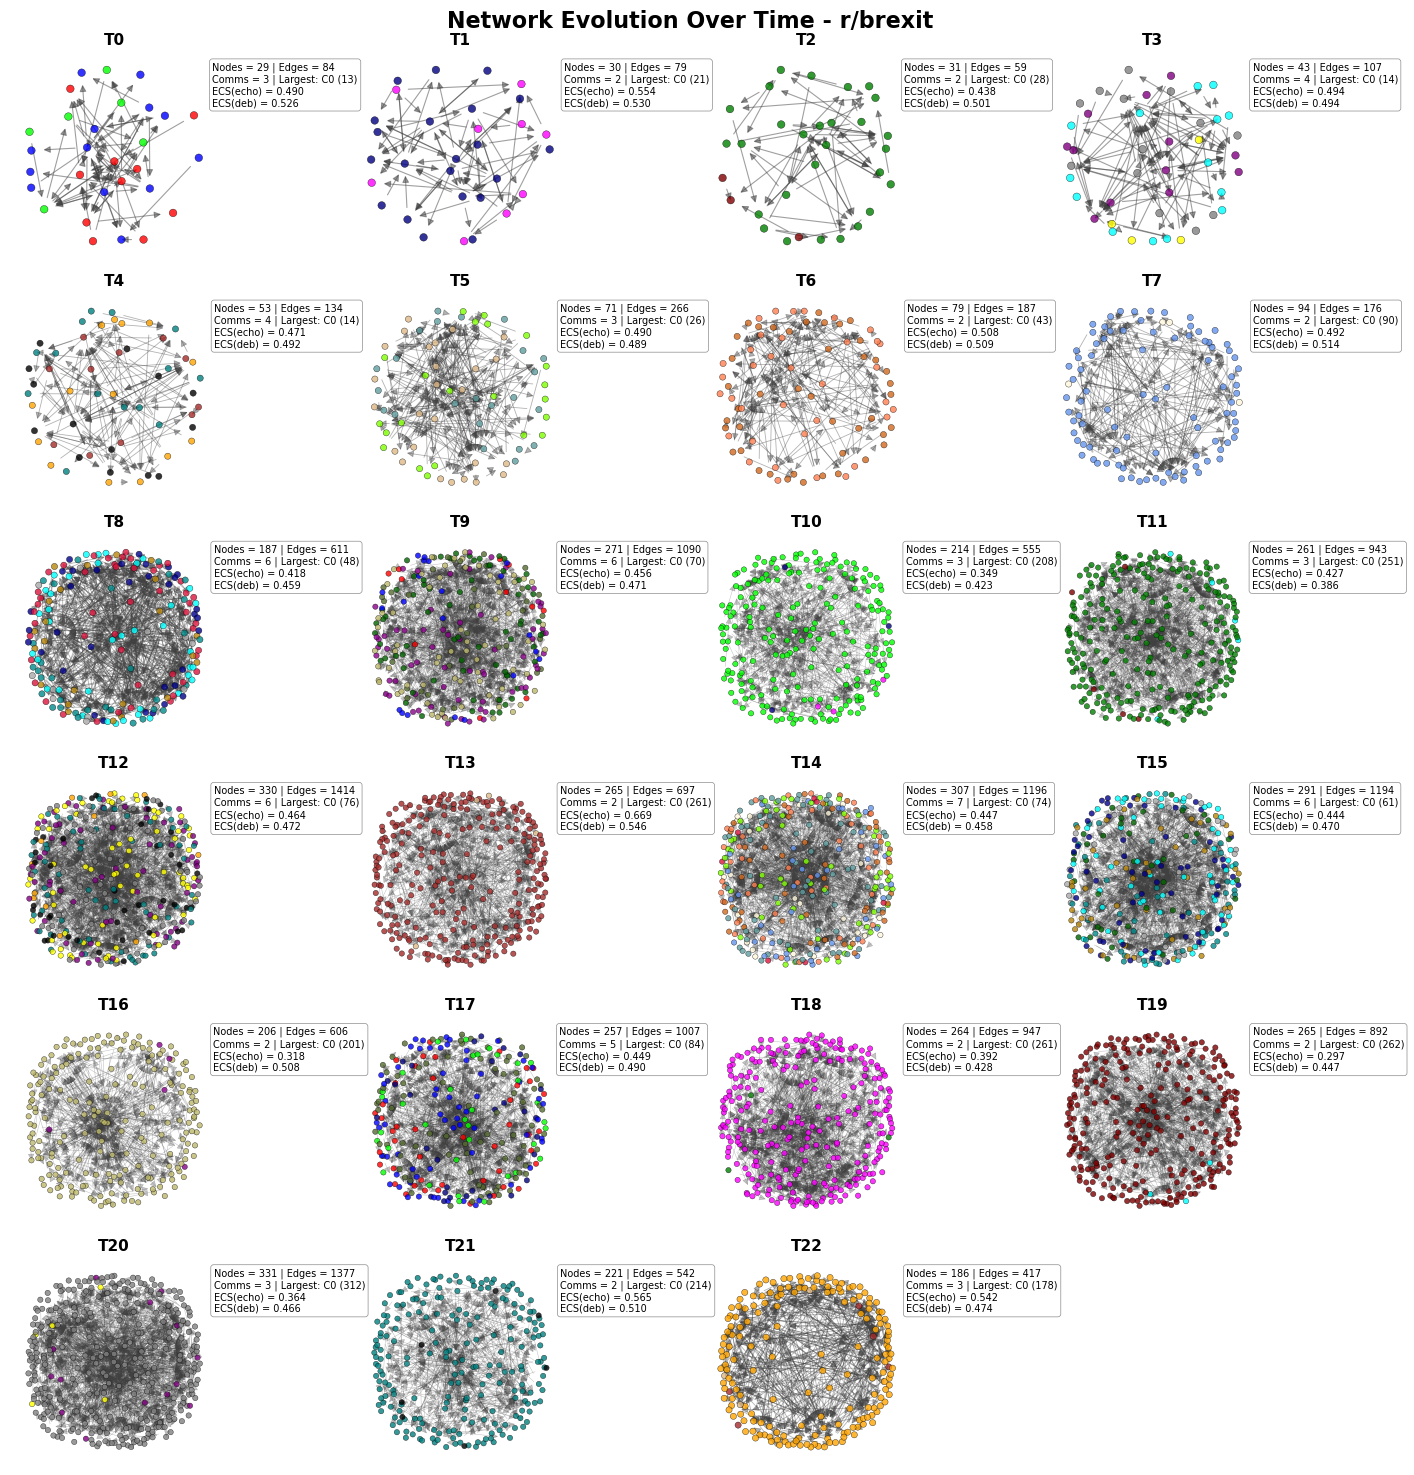


RESULTS SUMMARY
DATASET OVERVIEW:
   + Subreddits analyzed: 5
   + Total timesteps: 77
   + Total communities: 927

METHOD COMPARISON:
   + EchoGAE ECI: 0.454 ± 0.055
   + DebateGNN ECI: 0.402 ± 0.081
   + Paired t-test: t = 6.241, p = 0.000
   + Effect size (Cohen's d): 0.716 (medium)
   + Significant difference: Yes

COMMUNITY EVOLUTION (r/brexit - ID 0):
   + Average Jaccard similarity: 0.418
   + Average retention rate: 75.5%
   + Average growth rate: 36.7%


,n_timesteps,echogae_eci,debgnn_eci,delta_echogae_eci,delta_debgnn_eci,modularity,echogae_silhouette,debgnn_silhouette
subreddit,,,,,,,,
blacklivesmatter,10,0.482 ± 0.017,0.408 ± 0.074,0.005 ± 0.019,0.014 ± 0.043,0.852 ± 0.069,-0.19 ± 0.029,-0.311 ± 0.114
brexit,23,0.458 ± 0.084,0.481 ± 0.037,0.002 ± 0.105,-0.002 ± 0.043,0.161 ± 0.14,-0.111 ± 0.163,-0.067 ± 0.068
climate,26,0.468 ± 0.03,0.399 ± 0.053,-0.001 ± 0.023,0.0 ± 0.061,0.431 ± 0.242,-0.124 ± 0.063,-0.254 ± 0.105
democrats,9,0.407 ± 0.03,0.307 ± 0.04,0.005 ± 0.044,0.006 ± 0.056,0.18 ± 0.109,-0.211 ± 0.056,-0.404 ± 0.078
republican,9,0.42 ± 0.021,0.299 ± 0.046,-0.001 ± 0.032,0.0 ± 0.044,0.342 ± 0.122,-0.2 ± 0.04,-0.431 ± 0.089



Summary table saved to: results/ecs/ecs_summary_table.csv


In [17]:
import importlib
import src.visualization.ecs_plots
import src.visualization.snapshot_plots
import src.visualization.community_migration_plots
import src.visualization.community_sankey_plots
import src.utils.community_colors
importlib.reload(src.utils.community_colors)
importlib.reload(src.visualization.snapshot_plots)
importlib.reload(src.visualization.ecs_plots)
importlib.reload(src.visualization.community_migration_plots)
importlib.reload(src.visualization.community_sankey_plots)

import src.analysis.ecs_analyzer
importlib.reload(src.analysis.ecs_analyzer)

from src.analysis.ecs_analyzer import ECSAnalyzer

analyzer = ECSAnalyzer(output_dir='results/ecs')
results = analyzer.run_complete_analysis_with_figures(
    processed_dict=processed_dict,
    ecs_df=ecs_df,
    target_subreddit_id=0,
    embedding_timestep=12,
    # plot_all_embedding_timesteps=True,
    save_figures=True,
    color_mode="lineage"
)